In [ ]:
# Importing the zipfile to extract the data
import zipfile

#Unzip the data
zep_ref = zipfile.ZipFile("/content/drive/MyDrive/Data Set/cardamom_data.zip")
zep_ref.extractall()
zep_ref.close()

In [ ]:
# Inspect the data
import os

# Walk through the directory
for dirpath, dirnames, filenames in os.walk("cardamom_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'cardamom_data'.
There are 4 directories and 0 images in 'cardamom_data/train'.
There are 0 directories and 604 images in 'cardamom_data/train/Mixed image'.
There are 0 directories and 600 images in 'cardamom_data/train/Citrus sinensis'.
There are 0 directories and 624 images in 'cardamom_data/train/Elettaria cardamom'.
There are 0 directories and 594 images in 'cardamom_data/train/Amomum sublatum'.
There are 4 directories and 0 images in 'cardamom_data/val'.
There are 0 directories and 152 images in 'cardamom_data/val/Mixed image'.
There are 0 directories and 150 images in 'cardamom_data/val/Citrus sinensis'.
There are 0 directories and 157 images in 'cardamom_data/val/Elettaria cardamom'.
There are 0 directories and 149 images in 'cardamom_data/val/Amomum sublatum'.


In [ ]:
# Get the class_names programatically
import numpy as np
import pathlib

data_dir = pathlib.Path("cardamom_data/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['Amomum sublatum' 'Citrus sinensis' 'Elettaria cardamom' 'Mixed image']


In [ ]:
# Define directory dataset paths
train_dir = "cardamom_data/train"
test_dir = "cardamom_data/val"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (260,260)
BATCH_SIZE = 1

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode = 'categorical',
                                                                  image_size = IMG_SIZE,
                                                                  batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 2422 files belonging to 4 classes.
Found 608 files belonging to 4 classes.


In [ ]:
# Creating data augmentation layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zoom etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      #preprocessing.Rescale(1/255.)
])

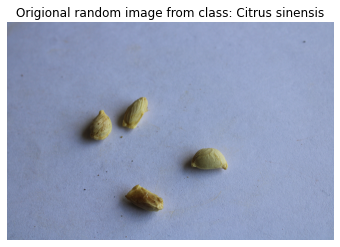

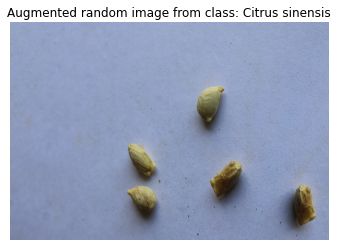

In [ ]:
# View a random image and comapre it to its augmented vwersion
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "cardamom_data/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Origional random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
plt.figure()
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup the shape and base model, freezing the base model layers
input_shape = (260, 260, 3)
base_model = tf.keras.applications.EfficientNetB2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation on Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)


# Put the dense layer on as the output
outputs = layers.Dense(4, activation='softmax', name="output_layers")(x)

# Make a model using the inputs and outputs
model = keras.Model(inputs, outputs)

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 260, 260, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
_________________________________________________________________
global_average_pooling_layer (None, 1408)              0         
_________________________________________________________________
output_layers (Dense)        (None, 4)                 5636      
Total params: 7,774,205
Trainable params: 5,636
Non-trainable params: 7,768,569
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps= len(test_data))

Epoch 1/10
2422/2422 [==============================] - 299s 119ms/step - loss: 0.1779 - accuracy: 0.9492 - val_loss: 0.0830 - val_accuracy: 0.9770
Epoch 2/10
2422/2422 [==============================] - 254s 105ms/step - loss: 0.0492 - accuracy: 0.9843 - val_loss: 0.0961 - val_accuracy: 0.9671
Epoch 3/10
2422/2422 [==============================] - 250s 103ms/step - loss: 0.0254 - accuracy: 0.9934 - val_loss: 0.0515 - val_accuracy: 0.9786
Epoch 4/10
2422/2422 [==============================] - 248s 102ms/step - loss: 0.0188 - accuracy: 0.9950 - val_loss: 0.0589 - val_accuracy: 0.9852
Epoch 5/10
2422/2422 [==============================] - 248s 102ms/step - loss: 0.0157 - accuracy: 0.9971 - val_loss: 0.0263 - val_accuracy: 0.9885
Epoch 6/10
2422/2422 [==============================] - 247s 102ms/step - loss: 0.0112 - accuracy: 0.9959 - val_loss: 0.0459 - val_accuracy: 0.9836
Epoch 7/10
2422/2422 [==============================] - 246s 102ms/step - loss: 0.0129 - accuracy: 0.9967 - val_

In [ ]:
test_loss, test_acc = model.evaluate(test_data, verbose = 1)
print("\n\ntest accuracy: ",test_acc)

608/608 [==============================] - 49s 80ms/step - loss: 0.0384 - accuracy: 0.9786


test accuracy:  0.9786184430122375


In [ ]:
# Let's create a function to plot our loss curves...
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss', c='r', marker='o', linestyle='dashed')
  plt.plot(epochs, val_loss, label='val_loss', c='b', marker='*', linestyle='dashed')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy', c='g', marker='o', linestyle='dashed')
  plt.plot(epochs, val_accuracy, label='val_accuracy', c='r', marker='*', linestyle='dashed')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

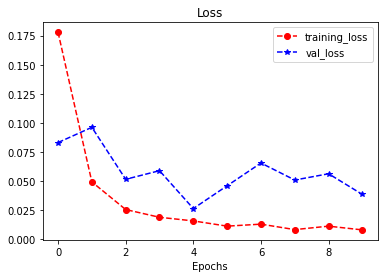

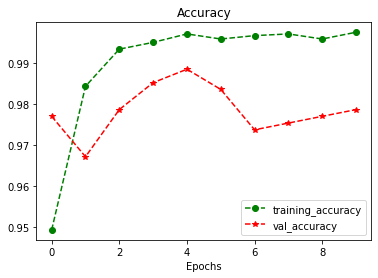

In [ ]:
# Check out our model's training curves
plot_loss_curves(history)

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
#Define a variable to store our model
MODEL_NAME = "cardamom_model_b2.h5"

In [ ]:
# Saving the model
model.save(MODEL_NAME)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
convert_bytes(get_file_size(MODEL_NAME), "MB")

File size: 30.235 Megabytes


## **TFLITE MODEL**

In [ ]:
# Convert the model
from tensorflow import lite
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9cgakjaw/assets


INFO:tensorflow:Assets written to: /tmp/tmp9cgakjaw/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
TF_LITE_MODEL_FILE_NAME = "cardamom_tf_lite_model_b2.tflite"

In [ ]:
# Save the model
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

8964320